In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from scipy.misc import imresize

%matplotlib inline
import pylab as pl
from IPython import display
import time

torch.cuda.set_device(1)

In [4]:

engine = nn.Linear(10,10)
test = Variable(torch.randn(10))
out = engine(test)
crit = nn.MSELoss()
targ = Variable(torch.zeros(10))
loss = crit(out, targ)
loss.backward()

In [2]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU()
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64)
        )
        
    def forward(self, inp):
        out = self.process(inp[:,:3,:,:])
#         outmask = self.LSM(self.rechannel(out).view(out.size(0),-1)).view(out.size(0),1,
#                                                                           out.size(2),out.size(2))
        return (out)
    
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.rechannel = nn.Sequential(
            Block(64,64),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, inp):
        out = self.rechannel(inp)
        return out

In [3]:
raw = torch.load('/data/imagenet/photos-annotated-0.pth')
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])])
dataset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
trainset = dataset[:64]
testset = dataset[-20:]


In [4]:
embed = ENCODER()
embed.load_state_dict(torch.load('../saved_models/meanpool_noaugment_cpu.pth'))
embed = embed.cuda()

def readin(li):
    return Variable(torch.cat([x[0].view(1,3,84,84) for x in li],dim=0).float(),volatile=True).cuda()

trainembeds = []
for cat in trainset:
    inp = readin(cat)
    embedlist = torch.zeros((0,64,10,10))
    for i in range(len(cat)//50+1):
        out = embed(inp[50*i:min(50*i+50,len(cat))]).data.cpu()
        embedlist = torch.cat([embedlist,out],dim=0)
    masklist = torch.cat([x[1].view(1,1,10,10) for x in cat],dim=0)
    trainembeds.append((embedlist,masklist))
print("Train embeds done")
# category, embed/mask, image
testembeds = []
for cat in trainset:
    inp = readin(cat)
    embedlist = torch.zeros((0,64,10,10))
    for i in range(len(cat)//50+1):
        out = embed(inp[50*i:min(50*i+50,len(cat))]).data.cpu()
        embedlist = torch.cat([embedlist,out],dim=0)
    masklist = torch.cat([x[1].view(1,1,10,10) for x in cat],dim=0)
    testembeds.append((embedlist,masklist))
print("Test embeds done")

trainset = trainembeds
testset = testembeds

Train embeds done
Test embeds done


In [5]:
def batchmaker(way,shot,theset,alterful=False):
    classes = np.random.choice(len(theset),way,replace=False)
    li = [[[theset[cl][0][i].view(1,64,10,10),theset[cl][1][i].view(1,10,10)] for i in 
           np.random.choice(len(theset[cl][0]),shot,replace=False)]
          for cl in classes]
    support = torch.cat([torch.cat([p[0] for p in t],dim=0) for t in li],dim=0)
    smask = torch.cat([torch.cat([p[1] for p in t],dim=0) for t in li],dim=0)
#     print(support.size(),query.size())
    return(Variable(support, volatile=(not alterful)).cuda(),
           Variable(smask, volatile=(not alterful), requires_grad=False).cuda()
          )

def evaluate(model,criterion,way,shot,reps,theset):
    losstracker = 0
    for i in range(reps):
        s,m = batchmaker(way,shot,theset)
        preds = model(s)
        
        # Val loss
        loss = criterion(preds,m)
        losstracker += loss.data[0]

    return losstracker/reps

way = 20
evalway = 20
trainshot = 128
testshot = 256
reps = 100

In [6]:
model = PREDICTOR().cuda()
losstracker,evallosstracker = [],[]
optimizer = None
nweights = sum([i.numel() for i in list(model.parameters())])
print(nweights," parameters in neural net.")

37633  parameters in neural net.


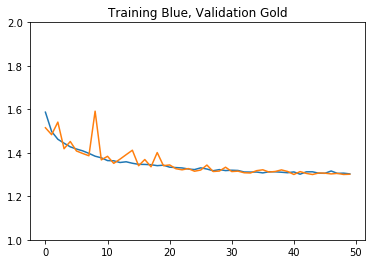

Train loss is: 1.303147431835532
Validation loss is: 1.3014959871768952

1788.2839088439941


In [7]:
# TRAIN!
criterion = nn.MSELoss() #nn.BCEWithLogitsLoss()
vbity = 200
epoch = 2000
start = time.time()

runningloss = 0
for it in range(5*epoch):
    if it%10==0:
        print(it)
    
    # Build batch
    support,targs = batchmaker(way,trainshot,trainset,alterful=True)
    
    # Predict
    model.zero_grad()
    preds = model(support)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(model.parameters(),lr=.001/(2**(it//epoch)))
    loss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity*10)
        model = model.eval()
        evalloss = evaluate(model,criterion,evalway,testshot,reps,testset)*10
        model = model.train()
        evallosstracker.append(evalloss)
        
        pl.figure()
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.ylim((1,2))
        pl.title("Training Blue, Validation Gold")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity*10)+
              "\nValidation loss is: "+str(evalloss)+"\n")
        runningloss = 0
        print(time.time()-start)

# MORE RECENT TEST
        

In [136]:
criterion = nn.NLLLoss().cuda()
embed = embed.eval()
print(evaluate(embed,model,criterion,evalway,trainshot,testshot*3,200,testset))
embed = embed.train()

(0.8775902589410544, 0.6654444444444444, 1.4411281701177359)


In [108]:
torch.sum(query[x],dim=0).size()

torch.Size([84, 84])

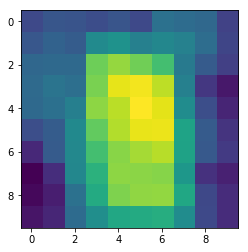

In [143]:
from matplotlib.pyplot import imshow
x = 2
imshow(mpreds[x][0].data.cpu().numpy())

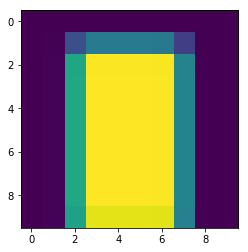

In [144]:
imshow(qmask[x][0].data.cpu().numpy())

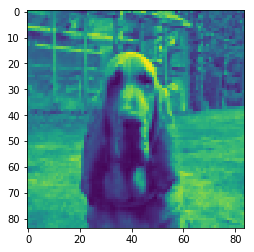

In [145]:
imshow(torch.sum(query[x],dim=0).data.cpu().numpy())


In [10]:
1.96*np.sqrt(.0090525/200)

0.01318637251104336

In [41]:
np.mean(evalacctracker[-50:])

0.5500666666666667

In [19]:
name = 'naive_full'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
embed,model,losstracker,evallosstracker,evalacctracker = torch.load('saved_models/naive_4.pth')

In [ ]:
Paper model achieves (over last 1000):
    0.71156711111111126
after 188500 iters

In [213]:
support = supportmaker(nclass,shot)
inp = inpmaker(nclass)
embeds = embed(support)
query = embed(inp)
model(embeds,query)

Variable containing:
-6.7075e-03 -5.0079e+00 -2.7911e+01
-2.9057e+00 -5.6263e-02 -4.5704e+01
-1.8272e+01 -4.3870e+01 -1.1600e-08
[torch.FloatTensor of size 3x3]